Dissecting mammalian spermatogenesis using spatial transcriptomics

ShortName: chen2021dissecting

Steps of processing the data from raw to Anndata:

In [1]:
# 1, Download the raw data from https://www.dropbox.com/s/ygzpj0d0oh67br0/Testis_Slideseq_Data.zip?dl=0

In [ ]:
# There are two groups of samples: WT and Diabetes
# WT: WT1,WT2,WT3
# Diabetes:Diabetes1,Diabetes2,Diabetes3

In [ ]:
# file format:
#     BeadLocationsForR_T3_Trimmed.csv
#     MappedDGEForR_T3_Trimmed.csv
#     PuckT3_bead_maxct_df.csv

In [71]:
# we have to standardize the names of three files of all samples to:
# BeadLocationsForR_T3_Trimmed.csv -> location.csv
# MappedDGEForR_T3_Trimmed.csv -> count.csv
# PuckT3_bead_maxct_df ->ct.csv

In [1]:
# take WT1 as an example:

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
import os
from scipy import sparse
import gc
import time
import tracemalloc

In [2]:
path = '/home/yzy/PUBDT/st/slideseq/testis/Data'

In [3]:
g1_sample= ['WT3','Diabetes_2','Diabetes_3']
g2_sample = ['WT1', 'WT2', 'Diabetes_1']
# the raw format of group1 and group2 is different.
# the first character of count file of group1 is a ","
# the first character of count file of group2 is a barcode str

### time and memory cost of loading raw data

In [ ]:
time_list = []
mem_list = []
dataset_list = []
for dataset in os.listdir(path):
    tracemalloc.start()
    time_st = time.time()

    count_file = f'{path}/{dataset}/count.csv'
    location_file = f'{path}/{dataset}/location.csv'    
    ct_file = f'{path}/{dataset}/ct.csv'    
    count = pd.read_csv(count_file)
    loc = pd.read_csv(location_file)
    ct = pd.read_csv(ct_file)
    
    if dataset in g1_sample:
        X = sparse.csr_matrix(count.values[:,2:].astype('int'))
    else:
        X = sparse.csr_matrix(count.values[:,1:].astype('int'))


    adata = ad.AnnData(X=X)
    
    adata.obsm['spatial'] = loc[['x','y']].values.astype('float')
    adata.obs['ct'] = ct.values[:,-1].astype('str')
    adata.obs['ct'] = adata.obs['ct'].astype('category')
    if dataset in g1_sample:
        adata.var_names = count.columns[2:]
    else:
        adata.var_names = count.columns[1:]

    cur_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_ed = time.time()
    cur_time = time_ed-time_st
    
    time_list.append(cur_time)
    mem_list.append(cur_mem)

    dataset_list.append(dataset)
    adata.write_h5ad(f'{dataset}.h5ad')
    print(dataset,cur_time,cur_mem)
    
    del count
    del loc
    del ct
    del adata
    del X
    gc.collect()

/tmp/ipykernel_991605/3725758603.py:21: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X)


Diabetes_2 1600.8362257480621 (8628926014, 33224309447)


/tmp/ipykernel_991605/3725758603.py:21: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X)


WT2 1059.2155048847198 (6688664996, 18847162312)


/tmp/ipykernel_991605/3725758603.py:21: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X)


WT3 1234.9611387252808 (7852309063, 29751758986)


In [13]:
time_list

[1600.8362257480621,
 1059.2155048847198,
 1234.9611387252808,
 1023.7648565769196,
 877.9024393558502,
 1058.9097385406494]

In [14]:
mem_list

[(8628926014, 33224309447),
 (6688664996, 18847162312),
 (7852309063, 29751758986),
 (6565009287, 18587847441),
 (5668953067, 15947038828),
 (6665392789, 25173567451)]

### time and memory cost of loading SODB data

In [8]:
import pysodb

In [9]:
time_list_sodb = []
mem_list_sodb = []
dataset_list_sodb = []
sodb = pysodb.SODB() # Initialization
data_list = ['WT1','WT2','WT3','Diabetes_1','Diabetes_2','Diabetes_3']
for sample in data_list:
    tracemalloc.start()
    time_st = time.time()
    adata = sodb.load_experiment('chen2021dissecting',sample)
    
    cur_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_ed = time.time()
    cur_time = time_ed-time_st
    
    time_list_sodb.append(cur_time)
    mem_list_sodb.append(cur_mem)

    dataset_list_sodb.append(sample)
    print(sample,cur_time,cur_mem)



/home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/urllib3-1.26.12-py3.9.egg/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gene.ai.tencent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


download experiment[WT1] in dataset[chen2021dissecting]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35.4M/35.4M [00:06<00:00, 5.96MB/s]


load experiment[WT1] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/WT1.h5ad
WT1 6.61503267288208 (39086197, 39090852)
download experiment[WT2] in dataset[chen2021dissecting]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47.0M/47.0M [00:09<00:00, 5.15MB/s]


load experiment[WT2] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/WT2.h5ad
WT2 9.938846826553345 (51048481, 51053136)
download experiment[WT3] in dataset[chen2021dissecting]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38.8M/38.8M [00:05<00:00, 7.97MB/s]


load experiment[WT3] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/WT3.h5ad
WT3 5.465709447860718 (42651501, 42656156)
download experiment[Diabetes_1] in dataset[chen2021dissecting]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35.3M/35.3M [00:05<00:00, 6.51MB/s]


load experiment[Diabetes_1] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/Diabetes_1.h5ad
Diabetes_1 5.998375654220581 (38627248, 38631910)
download experiment[Diabetes_2] in dataset[chen2021dissecting]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39.8M/39.8M [00:06<00:00, 6.47MB/s]


load experiment[Diabetes_2] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/Diabetes_2.h5ad
Diabetes_2 6.8083624839782715 (43724885, 43729547)
download experiment[Diabetes_3] in dataset[chen2021dissecting]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36.8M/36.8M [00:07<00:00, 4.98MB/s]


load experiment[Diabetes_3] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/Diabetes_3.h5ad
Diabetes_3 8.12538743019104 (40368891, 40373721)


In [15]:
time_list_sodb

[6.61503267288208,
 9.938846826553345,
 5.465709447860718,
 5.998375654220581,
 6.8083624839782715,
 8.12538743019104]

In [16]:
mem_list_sodb

[(39086197, 39090852),
 (51048481, 51053136),
 (42651501, 42656156),
 (38627248, 38631910),
 (43724885, 43729547),
 (40368891, 40373721)]

### time and memory cost of loading SODB data (preload)

In [17]:
time_list_sodb_pre = []
mem_list_sodb_pre = []
dataset_list_sodb_pre = []
sodb = pysodb.SODB() # Initialization
data_list = ['WT1','WT2','WT3','Diabetes_1','Diabetes_2','Diabetes_3']
for sample in data_list:
    tracemalloc.start()
    time_st = time.time()
    adata = sodb.load_experiment('chen2021dissecting',sample)
    
    cur_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_ed = time.time()
    cur_time = time_ed-time_st
    
    time_list_sodb_pre.append(cur_time)
    mem_list_sodb_pre.append(cur_mem)

    dataset_list_sodb_pre.append(sample)
    print(sample,cur_time,cur_mem)




/home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/urllib3-1.26.12-py3.9.egg/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gene.ai.tencent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


load experiment[WT1] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/WT1.h5ad
WT1 0.19594478607177734 (38927516, 38932339)
load experiment[WT2] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/WT2.h5ad
WT2 0.19559550285339355 (51033862, 51038517)
load experiment[WT3] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/WT3.h5ad
WT3 0.20695829391479492 (42645178, 42649833)
load experiment[Diabetes_1] in dataset[chen2021dissecting] from /home/yzy/anaconda3/envs/SODB/lib/python3.9/site-packages/pysodb-1.0.0-py3.9.egg/pysodb/cache/chen2021dissecting/Diabetes_1.h5ad
Diabetes_1 0.17715144157409668 (38622441, 38627271)
load experiment[Diabetes_2] in dataset[chen2021dissecting] from /home/yzy/anaconda3

In [18]:
time_list_sodb_pre

[0.19594478607177734,
 0.19559550285339355,
 0.20695829391479492,
 0.17715144157409668,
 0.21934843063354492,
 0.1915266513824463]

In [19]:
mem_list_sodb_pre

[(38927516, 38932339),
 (51033862, 51038517),
 (42645178, 42649833),
 (38622441, 38627271),
 (43719941, 43724603),
 (40364768, 40369430)]

## compare

In [23]:
pd_dict = {
    'method':[],
    'time':[],
    'memory':[],
    'sample':[]
}
pd_dict['time'].extend(time_list)
pd_dict['memory'].extend([m[1] for m in mem_list])
pd_dict['method'].extend(['RawLoad']*6)
pd_dict['sample'].extend(dataset_list)

pd_dict['time'].extend(time_list_sodb)
pd_dict['memory'].extend([m[1] for m in mem_list_sodb])
pd_dict['method'].extend(['SODBLoad']*6)
pd_dict['sample'].extend(dataset_list_sodb)

pd_dict['time'].extend(time_list_sodb_pre)
pd_dict['memory'].extend([m[1] for m in mem_list_sodb_pre])
pd_dict['method'].extend(['SODBLoad(preload)']*6)
pd_dict['sample'].extend(dataset_list_sodb_pre)



In [24]:
pd_df = pd.DataFrame(pd_dict)

In [29]:
pd_df.to_feather('benchmark_time_mem.feather')

In [27]:
33224309447/1000/1000/1000

33.224309447

In [30]:
import seaborn as sns

In [32]:
pd_df

,method,time,memory,sample
0,RawLoad,1600.836226,33224309447,Diabetes_2
1,RawLoad,1059.215505,18847162312,WT2
2,RawLoad,1234.961139,29751758986,WT3
3,RawLoad,1023.764857,18587847441,WT1
4,RawLoad,877.902439,15947038828,Diabetes_1
5,RawLoad,1058.909739,25173567451,Diabetes_3
6,SODBLoad,6.615033,39090852,WT1
7,SODBLoad,9.938847,51053136,WT2
8,SODBLoad,5.465709,42656156,WT3
9,SODBLoad,5.998376,38631910,Diabetes_1


In [42]:
import SOView
import numpy as np

<AxesSubplot:xlabel='method', ylabel='memory'>

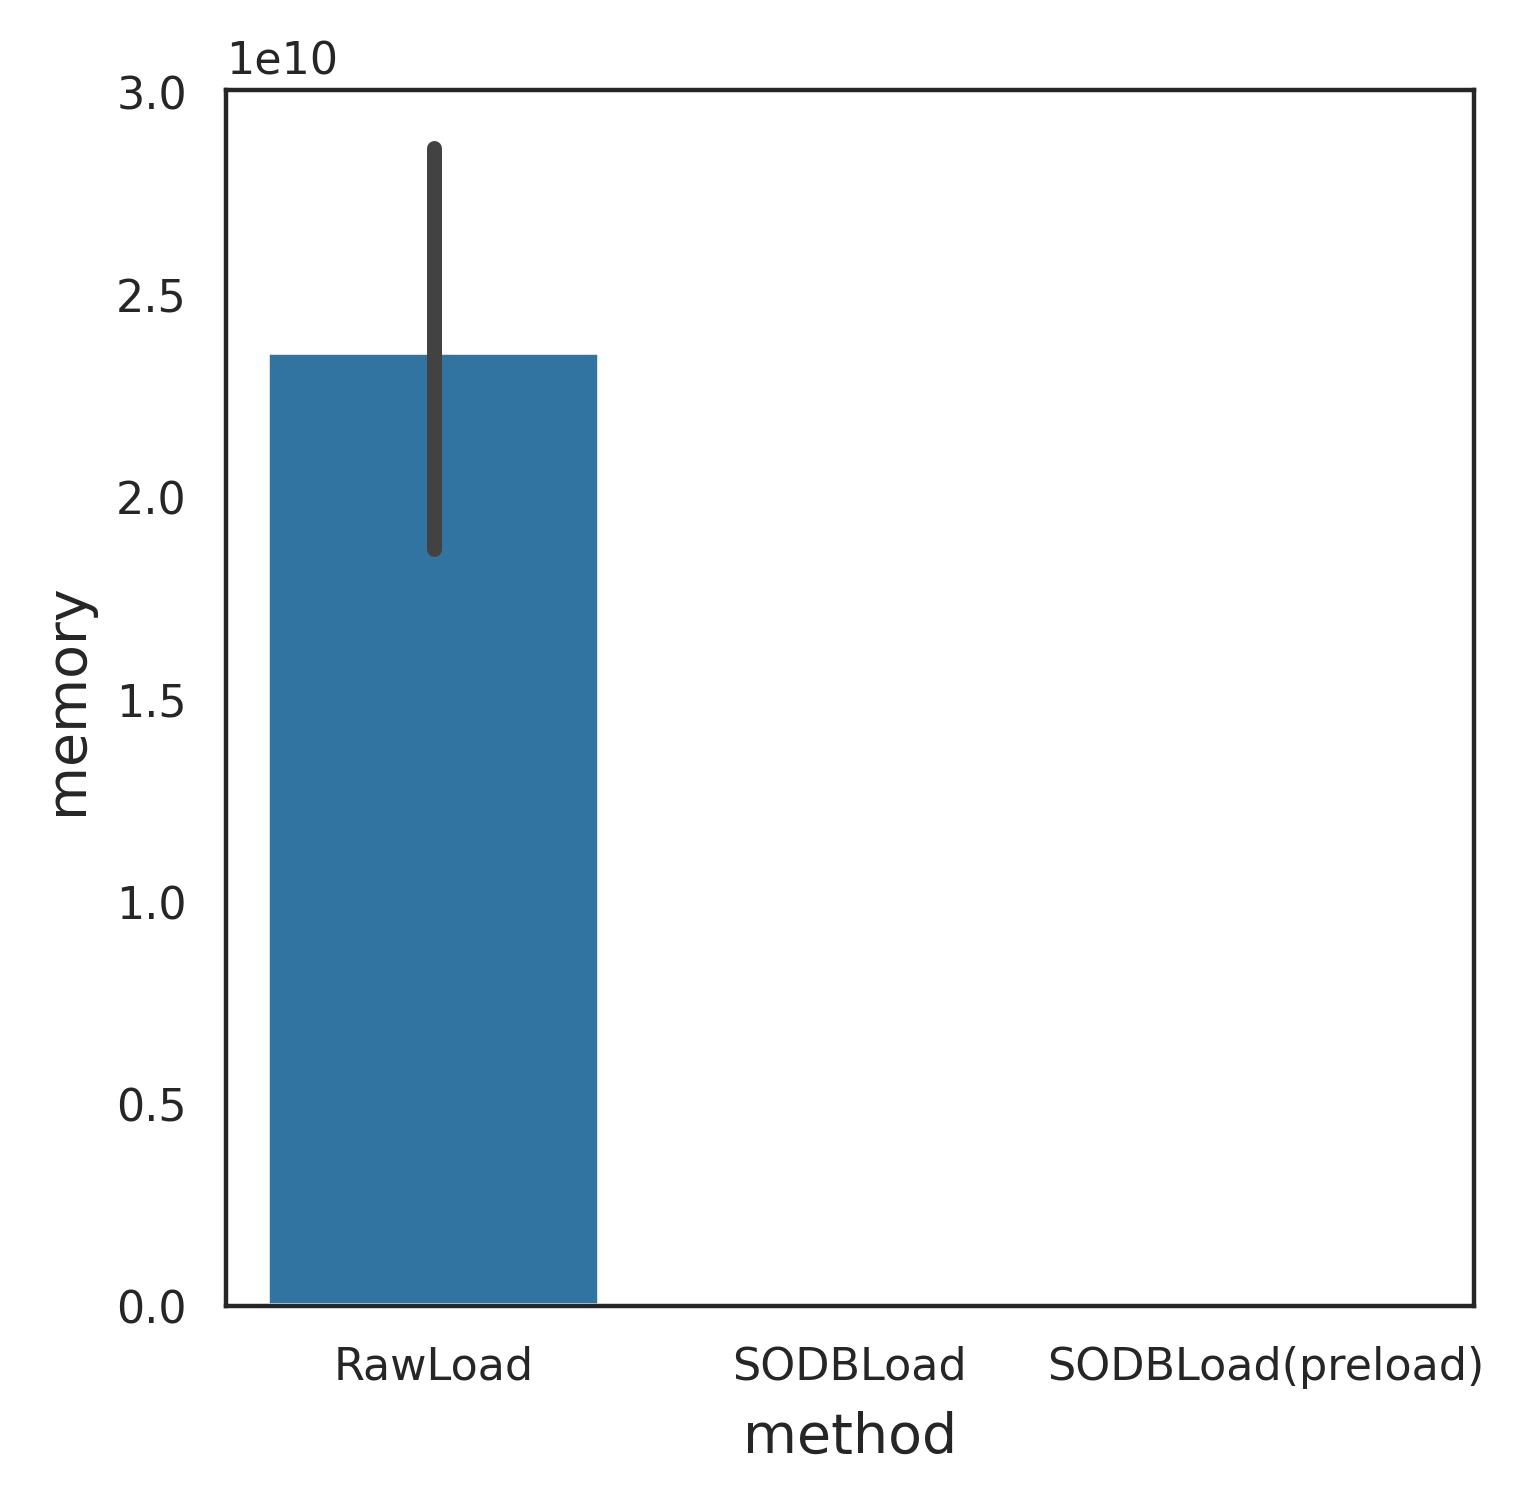

In [48]:
sns.barplot(data=pd_df,x='method',y='memory')

In [46]:
pd_df[['mem_log']] = np.log10(pd_df[['memory']])

<AxesSubplot:xlabel='method', ylabel='mem_log'>

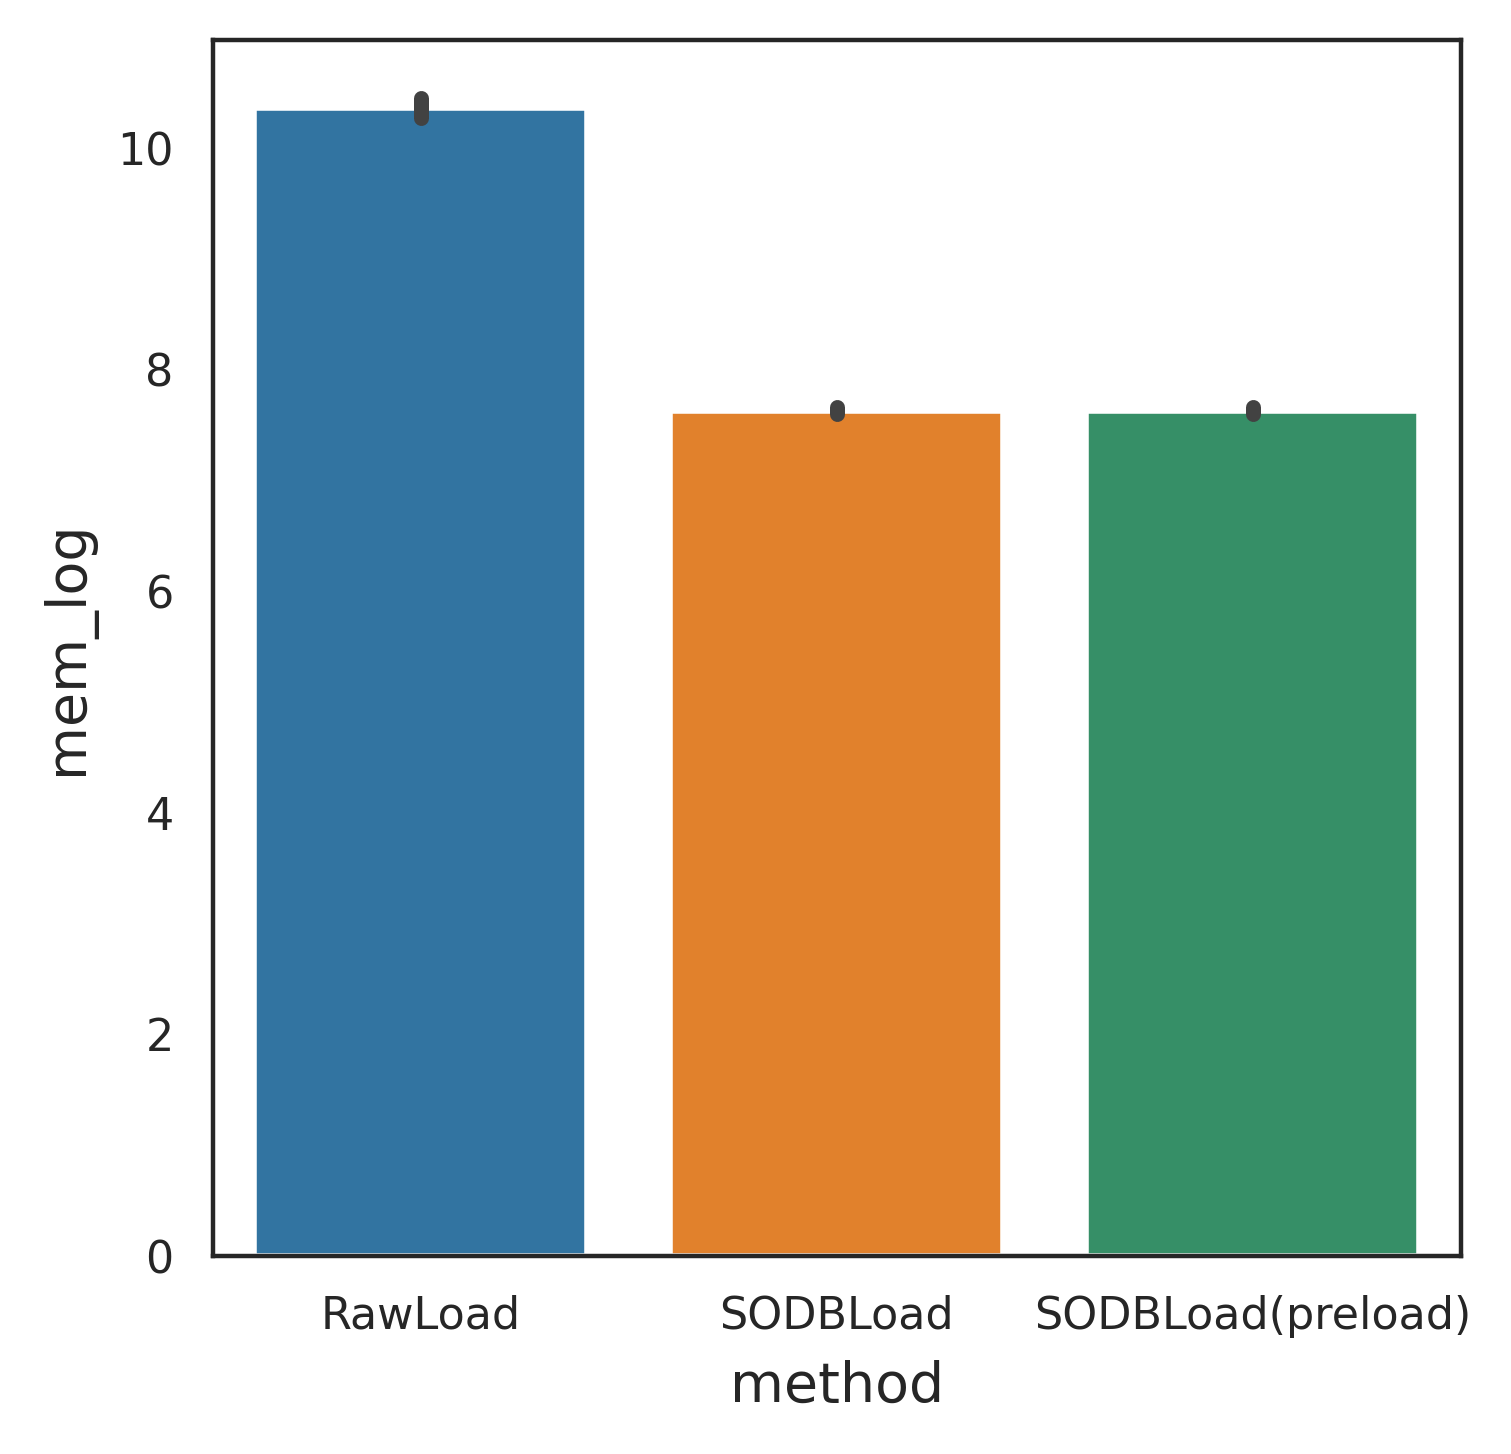

In [47]:
sns.barplot(data=pd_df,x='method',y='mem_log')

<AxesSubplot:xlabel='method', ylabel='time'>

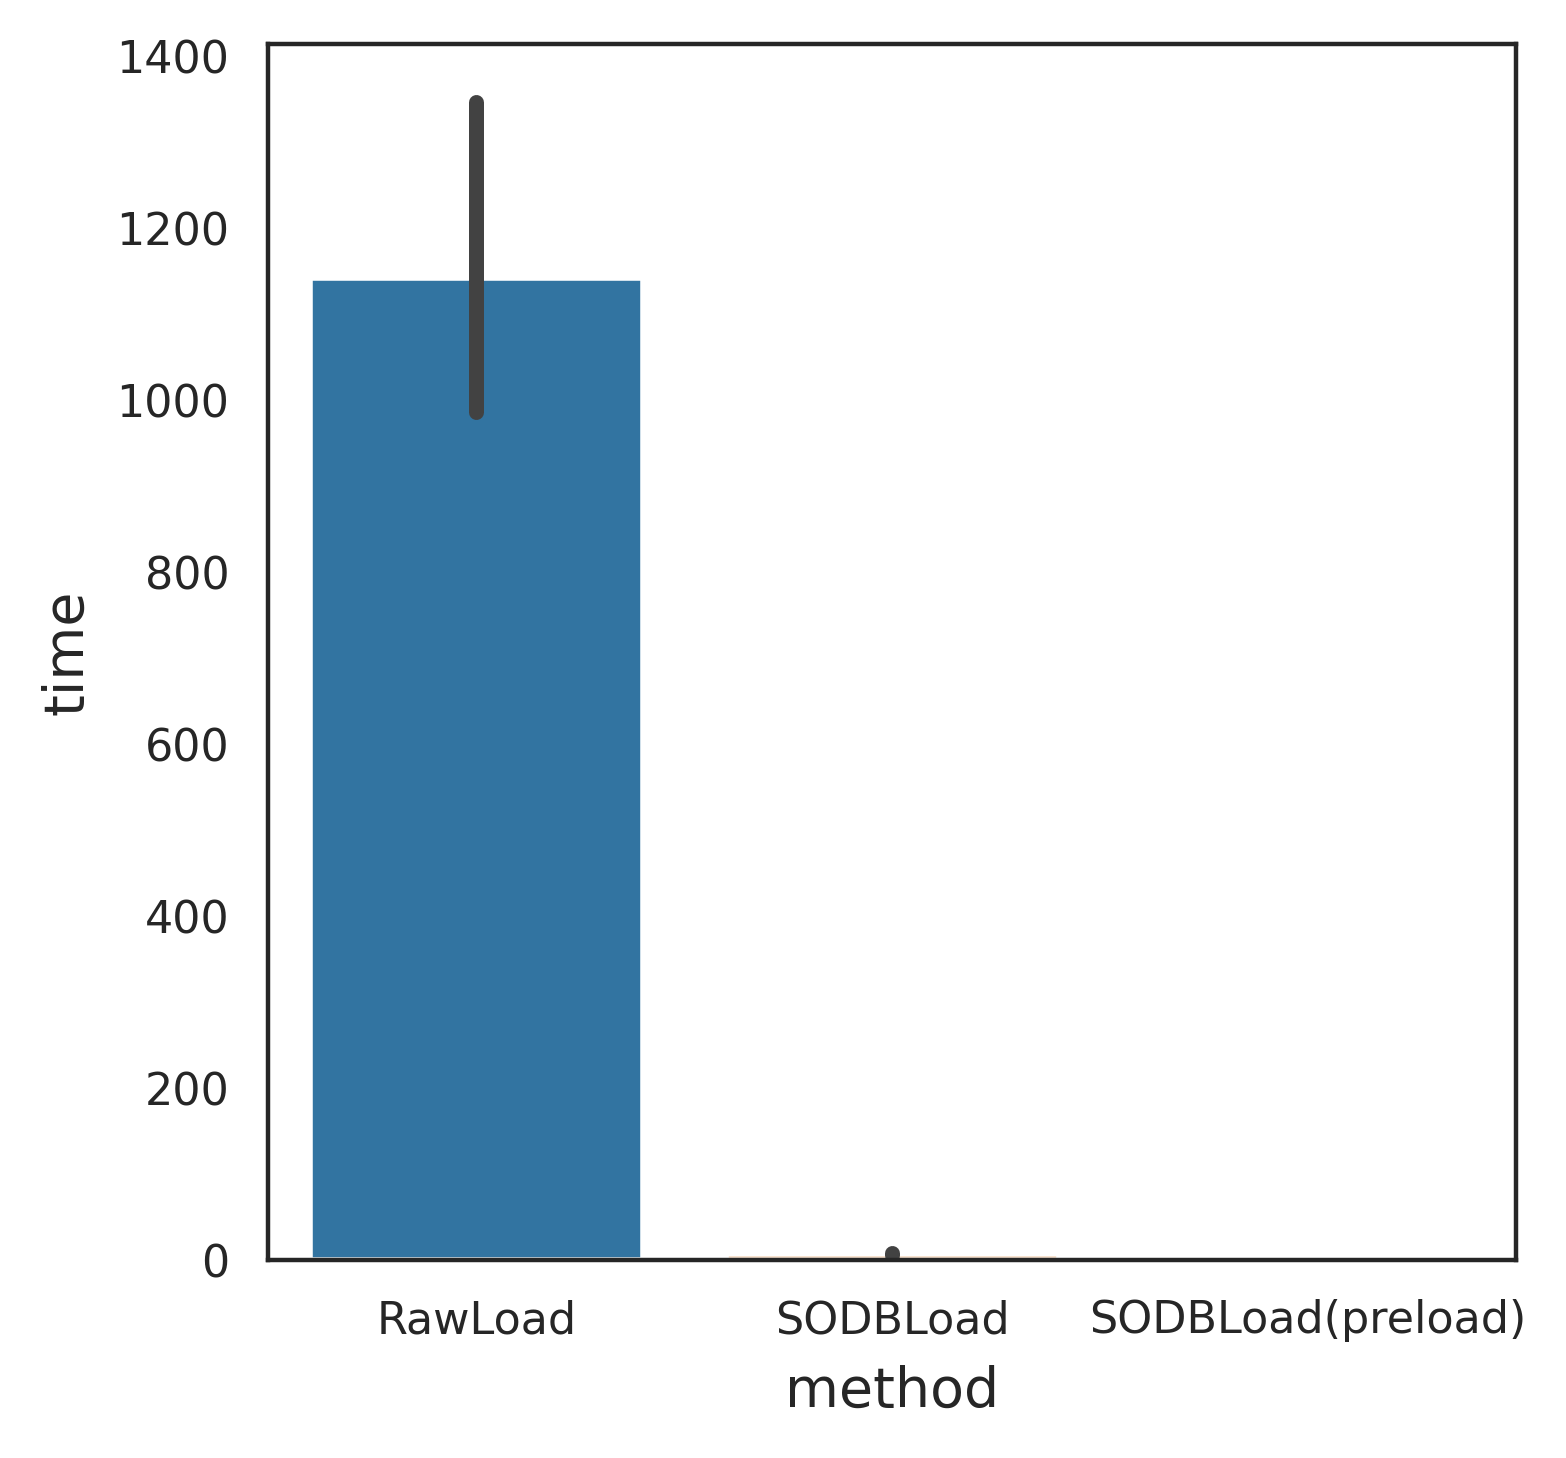

In [49]:
sns.barplot(data=pd_df,x='method',y='time')

In [50]:
pd_df[['time_log']] = np.log10(pd_df[['time']])

<AxesSubplot:xlabel='method', ylabel='time_log'>

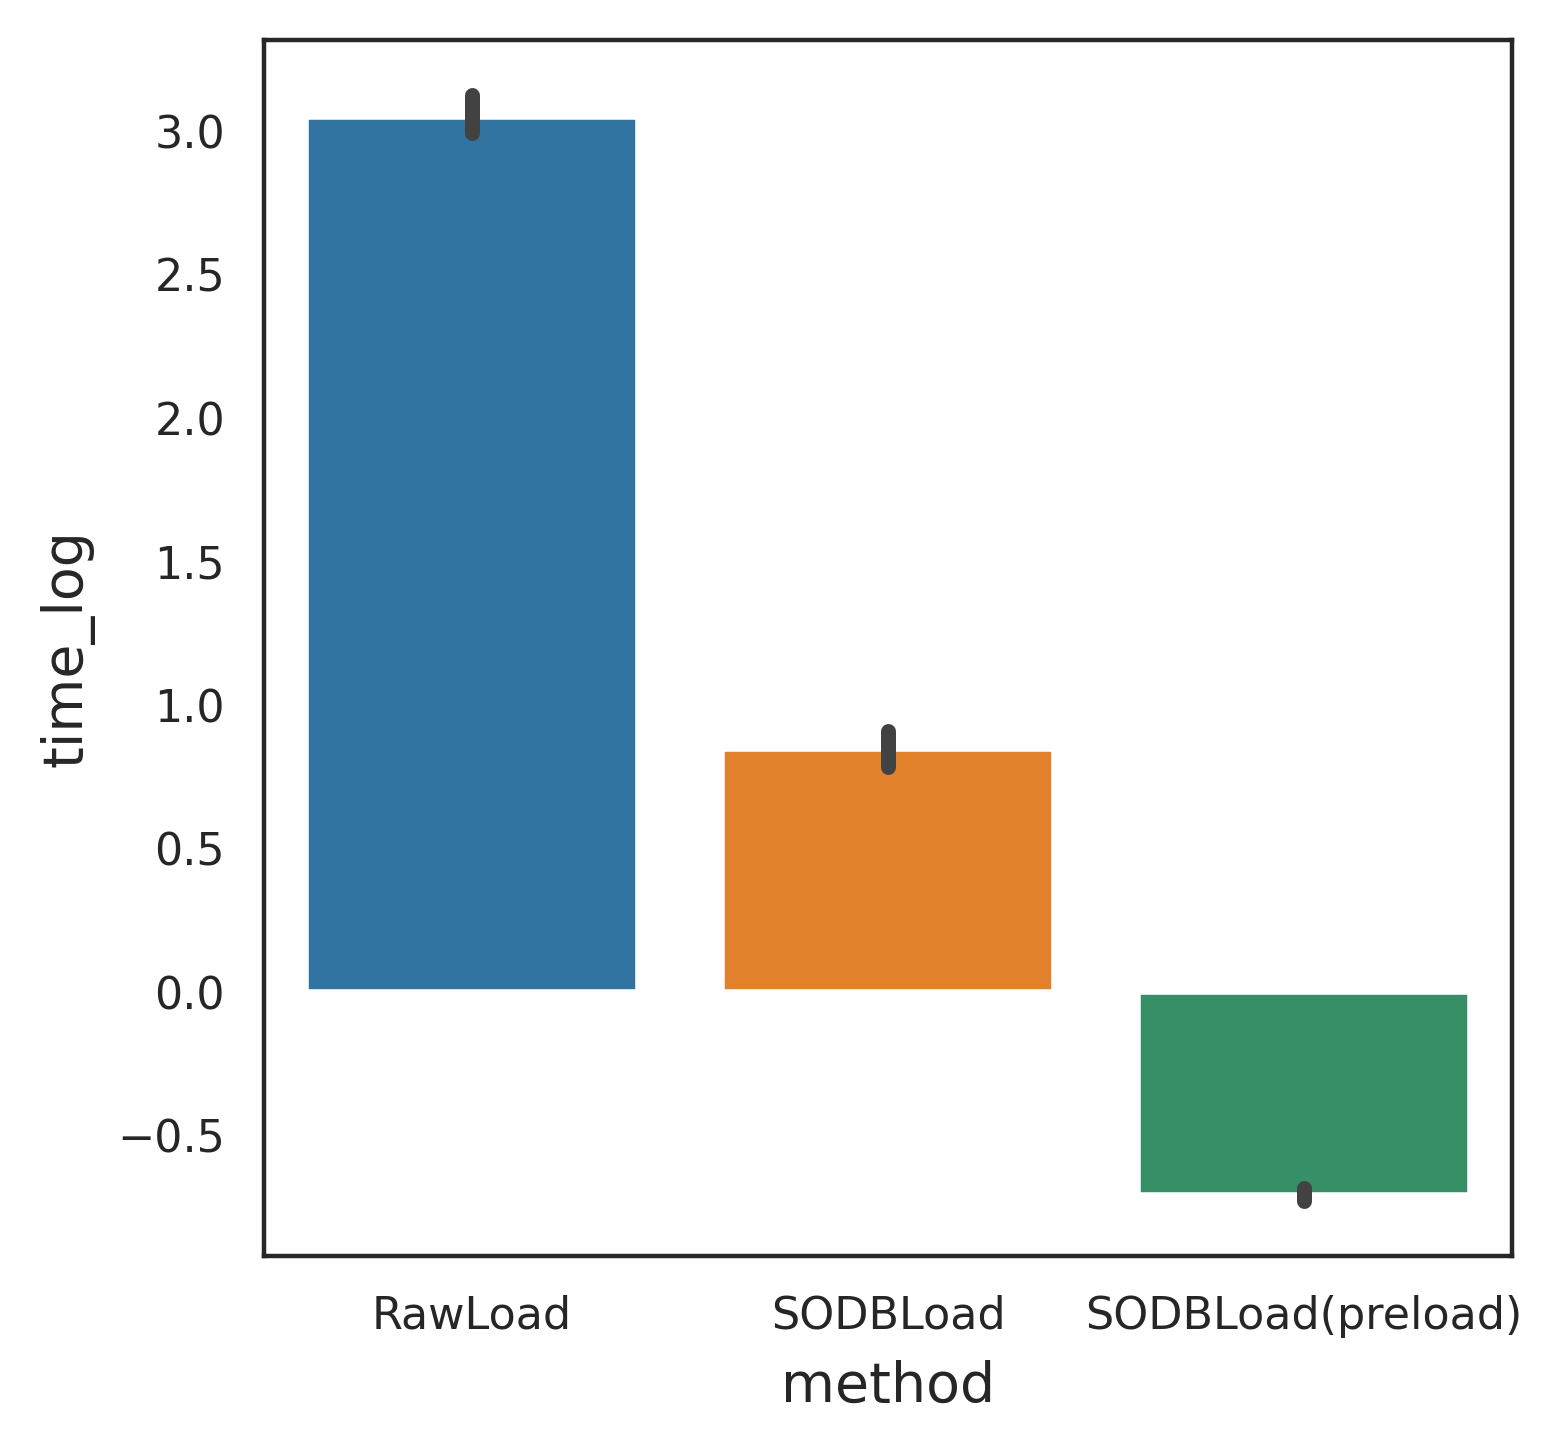

In [51]:
sns.barplot(data=pd_df,x='method',y='time_log')

In [57]:
pd_df[['time_min']] = pd_df[['time']]/60
pd_df[['mem_gb']] = pd_df[['memory']]/1024/1024/1024



In [58]:
pd_df.groupby('method').agg('median')

/tmp/ipykernel_991605/4287057475.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_df.groupby('method').agg('median')


,time,memory,mem_log,time_log,time_h,mem_gb,time_min
method,,,,,,,
RawLoad,1059.062622,2.201036e+10,10.338095,3.024922,0.294184,20.498750,17.651044
SODBLoad,6.711698,4.151494e+07,7.618040,0.826787,0.001864,0.038664,0.111862
SODBLoad(preload),0.195770,4.150963e+07,7.617985,-0.708254,0.000054,0.038659,0.003263


In [59]:
pd_df.groupby('method').agg('mean')

/tmp/ipykernel_991605/2999874510.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd_df.groupby('method').agg('mean')


,time,memory,mem_log,time_log,time_h,mem_gb,time_min
method,,,,,,,
RawLoad,1142.598317,2.358861e+10,10.357178,3.049915,0.317388,21.968609,19.043305
SODBLoad,7.158619,4.258922e+07,7.627317,0.846072,0.001989,0.039664,0.119310
SODBLoad(preload),0.197754,4.255700e+07,7.626966,-0.704819,0.000055,0.039634,0.003296


In [1]:
331194876/1000/1000

331.19487599999997